In [11]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint

# reading docfiles
import docx2txt

#nltk
import nltk
from nltk.tokenize import word_tokenize

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [12]:
word_exclusions = pd.read_excel("input/word_exclusions.xlsx")

word_exclusions = word_exclusions[word_exclusions["exclude"] == 1]

word_exclusions = word_exclusions.drop(columns=['exclude', 'exclude_short_list'], axis = 1)

In [13]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('german')
stop_words.extend(word_exclusions["word"])
stop_words.extend(["gut"])

In [14]:
df = pd.read_excel("input/app_v1/app_v1_feedback.xlsx")

In [15]:
df.head()

,transcript_id,person_id,segment_id,context,lesson,text,category_id
0,ss_01,p_01,s_001,NaN,NaN,Das ist in Ordnung.,1
1,ss_01,p_01,s_002,NaN,NaN,"Eine kurze Zwischenfrage, wann soll die App ei...",1
2,ss_01,p_01,s_003,In der ersten Version läuft die jetzt schon se...,NaN,Interessant. Okay.,1
3,ss_01,p_01,s_004,"Ich würde einfach anfangen, ein bisschen allge...",NaN,"Nein, soweit nicht. Alles klar.",1
4,ss_01,p_01,s_005,"Perfekt, klasse. Ist das Ihre erste Schwangers...",NaN,Ja.,12


In [16]:
improvements = df[df["category_id"] == 10]

In [17]:
improvements = improvements.drop(columns=['transcript_id', 'person_id', 'segment_id', 'context', 'lesson', 'category_id'], 
             axis = 1)

In [18]:
improvements['text_processed'] = \
improvements['text'].map(lambda x: re.sub('[,.!?]', '', x))

In [19]:
improvements['text_processed'] = \
improvements['text_processed'].map(lambda x: x.lower())

In [20]:
feedback = improvements['text_processed']

feedback_token = feedback.apply(word_tokenize)
feedback_token.head()

35    [jetzt, sehen, sie, wahrscheinlich, die, start...
36    [ja, genau, vielleicht, hätte, ich, jetzt, „, ...
40    [hier, wäre, es, vielleicht, noch, hilfreich, ...
42    [während, der, schwangerschaft, hatte, ich, ko...
43    [genau, deswegen, würde, ich, jetzt, eher, hie...
Name: text_processed, dtype: object

In [44]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), 
                                             deacc = True))

C:\Users\vanandkuma\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\_memmapping_reducer.py:611: UserWarning: Failed to delete temporary folder: C:\Users\VANAND~1\AppData\Local\Temp\joblib_memmapping_folder_125020_9fa2bb9e459f4df8af8277871906b4fd_55b84863493847d097e2d0abd34af8c4
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\vanandkuma\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\_memmapping_reducer.py:611: UserWarning: Failed to delete temporary folder: C:\Users\VANAND~1\AppData\Local\Temp\joblib_memmapping_folder_125020_807a4632f307485b8350696c17c76faa_010aeb5a3de54d4fa67704a9681fc0bb
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\vanandkuma\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\_memmapping_reducer.py:611: UserWarning: Failed to delete temporary folder: C:\Users\VANAND~1\AppData\Local\Temp\joblib_memmapping_folder_125020_9fa2bb9e459f4df8af8277871906b4fd_d81a4b65baf84451883543d354d1996e


In [26]:
data = improvements.text_processed.values.tolist()
data_words = list(sent_to_words(data))

In [27]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['jetzt', 'sehen', 'sie', 'wahrscheinlich', 'die', 'startseite', 'okay', 'okay', 'das', 'heißt', 'ich', 'kann', 'jetzt', 'einfach', 'auf', 'jetzt', 'starten', 'gehen', 'oder', 'muss', 'ich', 'mich', 'erst', 'registrieren', 'okay', 'eine', 'ganz', 'komische', 'kleine', 'sache', 'aber', 'ich', 'hange', 'mich', 'unheimlich', 'an', 'diesem', 'wort', 'auf']


In [28]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [29]:
# Remove Stop Words
data_words_nostops = remove_stopwords(feedback_token)

In [30]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [31]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("de_core_news_sm", disable = ['parser', 'ner'])

In [32]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['sehen', 'wahrscheinlich', 'Startseit', 'heißen', 'einfach', 'starten', 'gehen', 'Registrier', 'ganz', 'komisch', 'klein', 'Sache', 'hängen', 'unheimlich', 'Wort']]


In [33]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]]


In [34]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('Registrier', 1),
  ('Sache', 1),
  ('Startseit', 1),
  ('Wort', 1),
  ('einfach', 1),
  ('ganz', 1),
  ('gehen', 1),
  ('heißen', 1),
  ('hängen', 1),
  ('klein', 1),
  ('komisch', 1),
  ('sehen', 1),
  ('starten', 1),
  ('unheimlich', 1),
  ('wahrscheinlich', 1)]]

In [39]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [40]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.023*"geben" + 0.020*"Frau" + 0.019*"app" + 0.019*"ändern" + '
  '0.017*"fällen" + 0.016*"Mensch" + 0.015*"schwangeren" + 0.014*"Sprache" + '
  '0.014*"lernen" + 0.014*"Richtlinie"'),
 (1,
  '0.036*"fällen" + 0.025*"Frage" + 0.024*"app" + 0.019*"dahingehend" + '
  '0.015*"Frau" + 0.015*"Verantwortung" + 0.014*"Kommunikation" + '
  '0.013*"Ansatz" + 0.013*"Erwartung" + 0.012*"kommunizieren"'),
 (2,
  '0.019*"Situation" + 0.015*"Beispiel" + 0.014*"ändern" + 0.013*"klar" + '
  '0.013*"finden" + 0.012*"vielleicht" + 0.012*"Frage" + 0.011*"offen" + '
  '0.011*"persönlich" + 0.010*"gehen"')]


In [41]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.846149475297384

Coherence Score:  0.4472720725236187


In [42]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.073599  0.096829       1        1  40.810848
2     -0.074305 -0.096521       2        1  38.319420
0      0.147904 -0.000308       3        1  20.869732, topic_info=            Term       Freq      Total Category  logprob  loglift
519       fällen  21.000000  21.000000  Default  30.0000  30.0000
260        geben   6.000000   6.000000  Default  29.0000  29.0000
503         Frau  12.000000  12.000000  Default  28.0000  28.0000
68     Situation   9.000000   9.000000  Default  27.0000  27.0000
506  dahingehend   9.000000   9.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
165          app   4.534037  17.468589   Topic3  -3.9603   0.2181
519       fällen   4.007645  21.184081   Topic3  -4.0837  -0.0982
196       machen   2.211123   5.227766   Topic3  -4.6784   0.7064
4        einfach   2.045277   4.920873   Topic3  -4.7564   0.6889
21        gerade   1.854650   5.971849   Topic3  -4.8542   0.3975

[158 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
563       1  0.946813       Ansatz
322       1  0.860600      Antwort
322       2  0.215150      Antwort
427       3  0.759547      Aufgabe
566       1  0.854838  Bedürfnisse
...     ...       ...          ...
285       1  0.283091       ändern
285       2  0.424636       ändern
285       3  0.353864       ändern
275       2  0.998031    überlegen
276       2  0.639708   überprüfen

[158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=num_topics, random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=1, 
                                                        limit=30, 
                                                        step=1)

In [29]:
os.chdir("C:\\Users\\vanandkuma\\Documents\\projects\\sentiment_analysis")

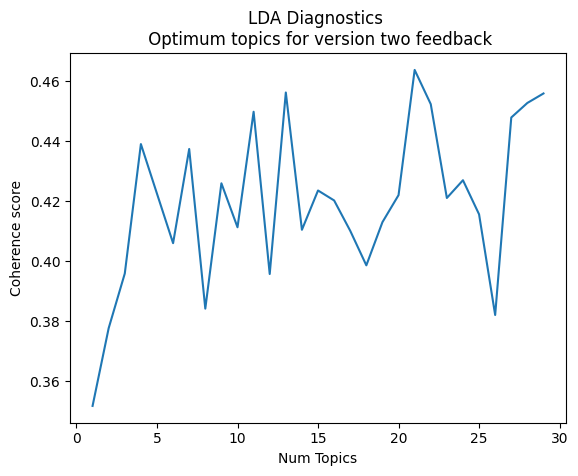

In [30]:
# Show graph
limit=30; start=1; step=1;
x = range(start, limit, step)
plt.title("LDA Diagnostics \n Optimum topics for version two feedback")
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.savefig('output/app_v1_lda_topic_coherence.png')

In [31]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.3518
Num Topics = 2  has Coherence Value of 0.3777
Num Topics = 3  has Coherence Value of 0.3959
Num Topics = 4  has Coherence Value of 0.439
Num Topics = 5  has Coherence Value of 0.4225
Num Topics = 6  has Coherence Value of 0.406
Num Topics = 7  has Coherence Value of 0.4374
Num Topics = 8  has Coherence Value of 0.3842
Num Topics = 9  has Coherence Value of 0.426
Num Topics = 10  has Coherence Value of 0.4113
Num Topics = 11  has Coherence Value of 0.4498
Num Topics = 12  has Coherence Value of 0.3957
Num Topics = 13  has Coherence Value of 0.4562
Num Topics = 14  has Coherence Value of 0.4105
Num Topics = 15  has Coherence Value of 0.4236
Num Topics = 16  has Coherence Value of 0.4202
Num Topics = 17  has Coherence Value of 0.4101
Num Topics = 18  has Coherence Value of 0.3986
Num Topics = 19  has Coherence Value of 0.413
Num Topics = 20  has Coherence Value of 0.422
Num Topics = 21  has Coherence Value of 0.4637
Num Topics = 22  has Cohere

In [30]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.056*"lernen" + 0.029*"mögen" + 0.029*"uber" + 0.026*"Frage" + '
  '0.020*"geben" + 0.019*"stellen" + 0.019*"fur" + 0.015*"personlich" + '
  '0.015*"Person" + 0.015*"hineinversetzen"'),
 (1,
  '0.052*"finden" + 0.041*"gut" + 0.029*"Lektion" + 0.020*"einfach" + '
  '0.020*"eigen" + 0.016*"Kommunikation" + 0.013*"Klicke" + 0.013*"personlich" '
  '+ 0.012*"kurz" + 0.011*"mögen"'),
 (2,
  '0.055*"gut" + 0.055*"finden" + 0.035*"Beispiel" + 0.021*"immer" + '
  '0.018*"geben" + 0.018*"Alltag" + 0.013*"personlich" + 0.013*"wichtig" + '
  '0.013*"mögen" + 0.013*"wirklich"'),
 (3,
  '0.027*"Thema" + 0.024*"nie" + 0.024*"bissch" + 0.024*"mögen" + '
  '0.023*"Geburt" + 0.020*"Seite" + 0.020*"finden" + 0.017*"Kommunikation" + '
  '0.016*"fur" + 0.014*"spannend"'),
 (4,
  '0.051*"Lektion" + 0.039*"gut" + 0.039*"Idee" + 0.026*"mögen" + '
  '0.026*"finden" + 0.026*"kommen" + 0.014*"total" + 0.014*"folgen" + '
  '0.014*"dazwischen" + 0.014*"Kleinigkeit"'),
 (5,
  '0.077*"mögen" + 0.028*"neutra

In [43]:
pyLDAvis.save_html(vis, 'output/ldavis_app_v1_improvements.html')